# Подсистема сегментации

###Сегментация фильмов  с камер видеонаблюдения

### Импортируем модули, необходимые для захвата видео и использования сверточных нейронных сетей.

In [6]:
%pylab inline
pylab.rcParams['figure.figsize'] = 14, 10


import os
import io
import sys
import time
import traceback
import codecs
import pandas as pd

import cv2
from scipy import signal

#хотим использовать доработанную нами версию pycaffe
#sys.path.append('/home/sergey/Documents/VideoPoisk/Experiments/2.SceneCutter/caffe_nikfi')
#sys.path.append('/home/sergey/newcaffe/python')
sys.path.insert(0, '/home/sergey/newcaffe/python')
import caffe
#import caffe_nikfi as caffe

Populating the interactive namespace from numpy and matplotlib


##Утилиты для работы с Caffe и OpenCV

In [7]:

class StuffCaffeOpencv():
    
#==============================================================================
#       Инициализация параметров
#       -    STEP_FRAMES - интервал выбороки кадров из фильма в кадрах
#       -    MAXFRAME - предел длительности фильма в кадрах; 
#              0 - нет предела (весь фильм)
#       -    BUFFSIZE - максимальный размер минибатча 
#==============================================================================
    def __init__(self, 
                caffe_path,
                action_model = None,
                model_def = 'models/bvlc_googlenet/deploy.prototxt',
                pretrained_model = 'models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                center_only = True,
                image_dims = [256, 256],
                raw_scale = 255.0,
                channel_swap = [2, 1, 0],
                img_mean = None,
                BUFFSIZE = 32,
                is_gpu=True,
                STEP_FRAMES=8,
                MAXFRAME=1000):
        if caffe_path is not None:
            if not caffe_path.endswith("/"):
                caffe_path += "/"
            self.caffe_path = caffe_path     
            self.model_def = caffe_path + model_def
            self.pretrained_model = caffe_path + pretrained_model
            self.center_only = center_only
            self.image_dims = image_dims
            self.raw_scale = raw_scale
            self.channel_swap = channel_swap
            self.img_mean = img_mean
            self.BUFFSIZE = BUFFSIZE
            self.is_gpu = is_gpu
            self.STEP_FRAMES = STEP_FRAMES
            self.MAXFRAME = MAXFRAME
            self.caffe_path = caffe_path
            self.graph_db = None
            self.action_model_file = action_model
        
#==============================================================================
#     Настроить нейронную сеть
#==============================================================================
    def caffe_init(self):
        if self.is_gpu: 
            caffe.set_mode_gpu()
            print("GPU mode")
        else:
            caffe.set_mode_cpu()
            print("CPU mode")
        return caffe.Classifier(self.model_def, self.pretrained_model,
                    image_dims=self.image_dims, mean=self.img_mean,
                    raw_scale=self.raw_scale,
                    channel_swap=self.channel_swap)

#==============================================================================
#     Итератор по фильму позволяет получать кадры, упакованные в мини-батчи.
#     Входные данные:
#     -    fname - путь к файлу видео.
#     -    scene_cuts (опционально) - список границ сцен в миллисекундах. 
#           Если он задан, мини-батчи формируются с учетом этого, 
#           т.е. в мини-батч попадают только кадры из одной сцены, 
#           не более CUT_MAX_FRAMES.
#     -    CUT_MAX_FRAMES не должен быть больше 10 (ограничение реализации 
#           GoogLeNet) игнорируется если scene_cuts не задан!
#     -    STEP_FRAMES - интервал выбороки кадров из фильма в кадрах
#     -    MAXFRAME - предел длительности фильма в кадрах; 
#           0 - нет предела (весь фильм)
#     -    BUFFSIZE - максимальный размер минибатча    
#==============================================================================
    def frame_iterator(self, fname, scene_cuts=None, CUT_MAX_FRAMES=10):
        buff_cnt = 0
        buff = []
        pos_list = []
        cap = cv2.VideoCapture(fname)
        current_cut = 0
        if cap.isOpened():
            prev_frame = 0.
            
            try:
                while True:
                    ret = cap.grab()
                    if ret > 0:
                        pos_frames = cap.get(cv2.CAP_PROP_POS_FRAMES)
                        if self.MAXFRAME > 0 and pos_frames > self.MAXFRAME:
                            break
                        if pos_frames - prev_frame >= self.STEP_FRAMES:
                            if scene_cuts is None:
                                ret, bgr_frame = cap.retrieve()
                                frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
                                prev_frame = pos_frames   
                                buff_cnt += 1
                                buff.append(frame / 255.)
                                pos_list.append({'pos_frames': pos_frames})
                                if buff_cnt >= self.BUFFSIZE :    
                                    yield pos_list, buff
                                    buff_cnt = 0
                                    buff = []
                                    pos_list = []
                            else:
                                if buff_cnt < CUT_MAX_FRAMES and (
                                        current_cut >= len(scene_cuts) or                                    
                                        pos_frames < scene_cuts[current_cut] ):
                                    ret, frame = cap.retrieve()
                                    prev_frame = pos_frames   
                                    buff_cnt += 1
                                    buff.append(frame / 255.)
                                    pos_list.append({'pos_frames': pos_frames})
                                    
                                if current_cut < len(scene_cuts) and pos_frames >= scene_cuts[current_cut]:
                                    current_cut += 1
                                    if len(pos_list):
                                        yield pos_list, buff
                                        buff_cnt = 0
                                        buff = []
                                        pos_list = []
                    else:
                        break
            except GeneratorExit:
                pass
            except Exception:
                print traceback.format_exc()
            cap.release()
            cv2.destroyAllWindows()
            if len(pos_list) and (scene_cuts is None):
                yield pos_list, buff
            elif len(pos_list) and (scene_cuts is not None):
                yield pos_list, buff

In [8]:
def populate_rus_labels(the, labels_file):
    labels_df = []
    with codecs.open(os.path.join(the.caffe_path, labels_file), 'r', 'cp1251') as f:
        for l in f.readlines():
            synset_id = l.strip().split(' ')[0]
            words = ' '.join(l.strip().split(' ')[1:])
            word_eng = words.split(' - ')[0]
            word_rus = words.split(' - ')[1]
            labels_df.append(dict(synset_id=synset_id, 
                                  word_eng=word_eng, 
                                  word_rus=word_rus))

    return pd.DataFrame(labels_df)

###Получаем кадры из фильма, рассчитываем вектор признаков и по расстоянию между векторами определяем разрывы сцен

##OpenCV получает CV_CAP_PROP_POS_MSEC из заголовка файла, в видеонаблюдении неизвестно от какого начала, поэтому будем использовать номер кадра вместо таймкода.

In [9]:
def segmentize(fname, the, labels_df, classifier, SCENE_THR=3., POOLING_SIZE=10, WMIN=0.1):
    frm_count = 0
    frm_new_size = (256,256)
    DIST_THRE = 1.
    POOL_IDX_BY_N_FV = 10
    NTOPCATEGS = 5
    RELEASE = 5
    #x = np.array([-0.04340667,-0.46344629,0.,0.46344629,0.04340667])             #sigma 0.7
    x = np.array([-0.12689981,-0.21918588,0.,0.21918588,0.12689981])             #sigma 1.1
    FILTR = x
    
    NFILTR = len(FILTR)
    
    prev_feature_vect = None
    scene_distance = 0.
    online_scene_dists = [0.]
    online_scene_scene_keys = [0.]
    debug_scene_dists = [0.]
    debug_scene_scene_keys = [0.]
    debug_filtered_distances = [0.] * NFILTR
    scene_idx_list = []
    scene_fvectors = []
    scene_categs = []
    lastsofar = 0
    
    prev_dist = None
    was_peak = False
    
    for pos_list, frames in the.frame_iterator(fname, CUT_MAX_FRAMES=POOLING_SIZE):
        print 'Captured', pos_list[0]['pos_frames'], '-', pos_list[-1]['pos_frames'], 'frames'
        lastsofar = pos_list[-1]['pos_frames']
        #Вычисляем векторы признаков и классификаций
        #predictions, feature_vectors = classifier.predict(frames, False, blob = 'pool5/7x7_s1')
        predictions = classifier.predict(frames, False)
        feature_vectors = classifier.blobs['pool5/7x7_s1'].data
        for i in range(len(frames)):
            feature_vect = feature_vectors[i]
            if prev_feature_vect is not None:
                scene_distance = np.linalg.norm(prev_feature_vect - feature_vect)
                if scene_distance < DIST_THRE:
                    scene_distance = 0.
            prev_feature_vect = np.array(feature_vect)
            online_scene_dists.append(scene_distance) 
            debug_scene_dists.append(scene_distance)
            debug_scene_scene_keys.append(pos_list[i]['pos_frames'])
            
            if prev_dist is not None:               
                if scene_distance - prev_dist > SCENE_THR \
                and not was_peak:
                    was_peak = True
                    online_scene_scene_keys.append(debug_scene_scene_keys[-1]) 
                    if len(online_scene_scene_keys)>=2:
                        scene_descript = {
                            'start': online_scene_scene_keys[-2],
                            'end': online_scene_scene_keys[-1]
                        }                    
                        scene_idx_list.append(scene_descript)
                        scene_fvectors = []    
                        scene_categs = []
                if prev_dist - scene_distance >= SCENE_THR:
                    was_peak = False
            prev_dist = scene_distance
        
        
    if len(scene_idx_list)>0 and len(online_scene_scene_keys)>=1:
        scene_descript = {
                        'start': online_scene_scene_keys[-1],
                        'end': lastsofar
                        }
        
        scene_idx_list.append(scene_descript)
    return scene_idx_list, (debug_scene_dists, debug_scene_scene_keys, debug_filtered_distances)

###Вывод графика расстояний и границ сцен

In [10]:
def scene_plot(scene_distances, time_keys, scenes, mini=0, midi=0, maxi=0, w=14, h=6, picture=None, 
               SCENE_THR=22, pictures=None):
    fseconds = np.array(time_keys)
    if mini==0:
        min_idx = 0
    else:
        min_idx = np.where(fseconds>=mini)[0][0]
    if maxi==0:
        max_idx = len(scene_distances)
    else:
        max_idx = np.where(fseconds<=maxi)[0][-1]
    distances_array = np.array(scene_distances[min_idx:max_idx])
    fseconds = np.array(time_keys[min_idx:max_idx])
    if midi==0 and mini==0 and maxi==0:
        scene_cuts = np.array([k['start'] for k in scenes])
    else:
        scene_cuts = np.array([midi,])
    
    
    pylab.rcParams['figure.figsize'] = w, h
    plt.figure()
    if pictures is not None:
        for i in range(len(pictures)):
            plt.subplot(1, len(pictures)+1, i+1)
            plt.imshow(pictures[i])
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
        plt.subplot(1, len(pictures)+1, len(pictures)+1)
    elif picture is not None:
        plt.subplot(121)
        plt.imshow(picture)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.subplot(122)
        
    lines = plt.plot(fseconds, distances_array, 'b',
                 scene_cuts, 
                 np.ones(len(scene_cuts))*SCENE_THR, 'ro')
    plt.show()
    
    
    

## M.A.I.N.

In [13]:
#Настроить нейронную сеть

MAXFRAME = 5000
FPS = 15
STEP_FRAMES = int(round(FPS / 25. * 8.))

STEP_FRAMES = 8

the = StuffCaffeOpencv('/home/sergey/caffe',
                      model_def = 'models/bvlc_googlenet/deploy.prototxt',
                      pretrained_model = 'models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                      STEP_FRAMES=STEP_FRAMES,
                      MAXFRAME=MAXFRAME,
                      BUFFSIZE=10)
classifier = the.caffe_init()
labels_df = populate_rus_labels(the, 'data/ilsvrc12/synset_words_rus.csv')

POOLING_SIZE = 10


#Задать путь к фильму
fname = "/home/sergey/Videos/FREE/video2.flv"
#fname = "/home/sergey/Videos/bbc/V.velikom.kraju.Serengeti.2011.XviD.HDTVRip.ExKinoRay.avi"
#fname = "/home/sergey/Videos/bbc/V.velikom.kraju.Serengeti.2011.XviD.HDTVRip.ExKinoRay.avi"


GPU mode


###Выполняем сегментацию

In [14]:
#print help(cv2)
start_clock = time.clock()
SCENE_THR = 10.
scenes, (scene_distances, time_keys, filtered_distances) = segmentize(fname, the, labels_df, classifier, 
                                                                    POOLING_SIZE=10, SCENE_THR=SCENE_THR)
elapsed = time.clock() - start_clock
print 'elapsed', elapsed

PEAKFIND = 0
if PEAKFIND:
    scene_cuts = np.array(peakind) * STEP_FRAMES
else:
    scene_cuts = [s['start'] for s in scenes]

Captured 8.0 - 80.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 88.0 - 160.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 168.0 - 240.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 248.0 - 320.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 328.0 - 400.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 408.0 - 480.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 488.0 - 560.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 568.0 - 640.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 648.0 - 720.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 728.0 - 800.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 808.0 - 880.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 888.0 - 960.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 968.0 - 1040.0 frames
****SHAPE**** (10, 1024, 1, 1) (10, 1000) 10
Captured 1048.0 - 1120.0 fra

In [15]:
print scenes
print len(scene_distances)
print len(time_keys)

[{'start': 0.0, 'end': 248.0}, {'start': 248.0, 'end': 424.0}, {'start': 424.0, 'end': 1424.0}, {'start': 1424.0, 'end': 5000.0}]
626
626


##График расстояний

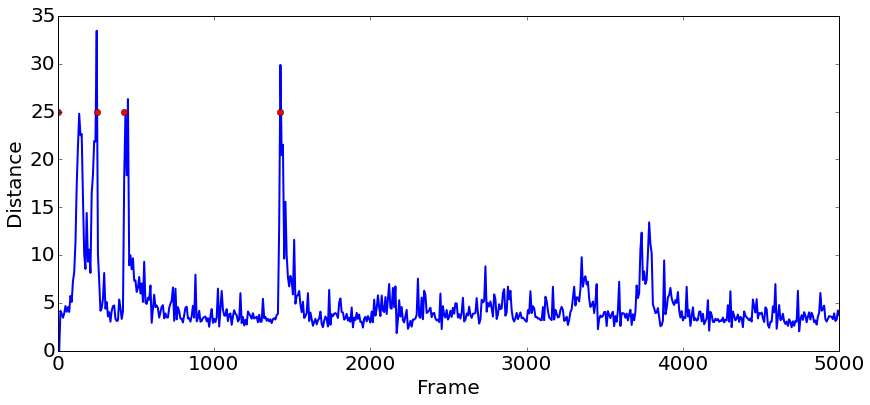

In [16]:
distances_array = np.array(scene_distances)
fseconds = np.array(time_keys)
scene_dots = [o['start'] for o in scenes]

if 1:
    pylab.rcParams['figure.figsize'] = 14, 6
    plt.figure()
    lines = plt.plot(fseconds, distances_array[:len(fseconds)], 'b',
                    scene_dots, 25*np.ones(len(scene_dots)), 'ro')
    plt.setp(lines, linewidth=2.0)
    fontsize = 20
    plt.ylabel("Distance", fontsize=fontsize)
    plt.xlabel("Frame", fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.show()
if 0:
    ##### !!!!!
    if PEAKFIND:
        peakind = signal.find_peaks_cwt(distances_array, np.arange(4,8), noise_perc=5)
    ##### !!!!!
    
    
    if PEAKFIND:
        plt.figure()
        lines = plt.plot(fseconds, distances_array[:len(fseconds)], 'b',
                    np.array(peakind)*STEP_FRAMES, np.ones(len(peakind))*10, 'ro')
        plt.setp(lines, linewidth=2.0)
        fontsize = 20
        plt.ylabel("Distance", fontsize=fontsize)
        plt.xlabel("Frame", fontsize=fontsize)
        plt.tick_params(axis='both', which='major', labelsize=fontsize)
        plt.show()
    else:
        scene_plot(scene_distances, time_keys, scenes, SCENE_THR=SCENE_THR)
    
    if PEAKFIND:
        print np.array(peakind)*STEP_FRAMES
    else:
        print scene_cuts

###Прототип интерфейса: ключевые кадры и график обзора фильма

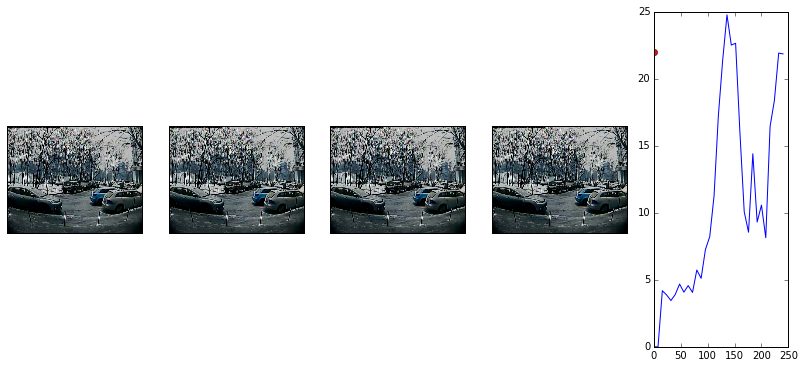

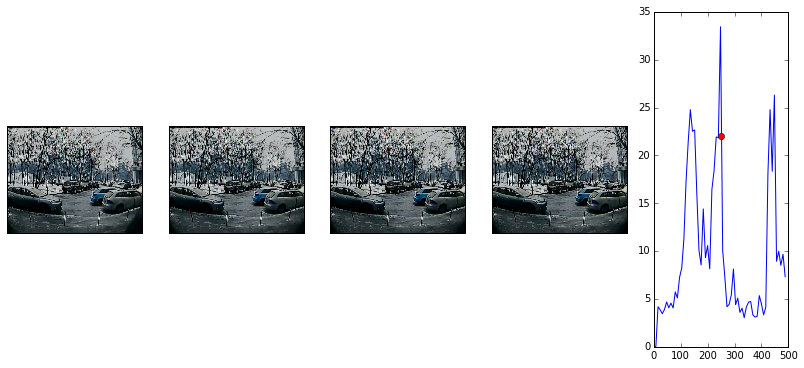

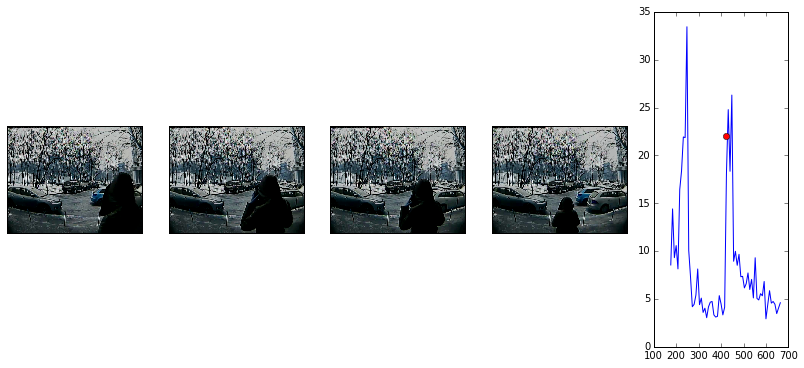

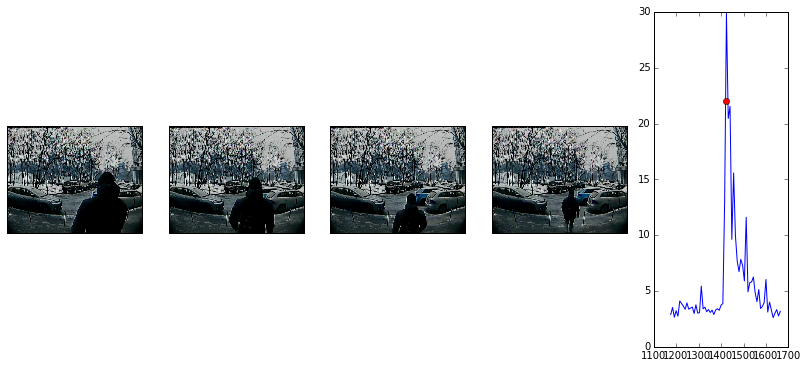

In [17]:
if 1:
    POOLING_SIZE = 5
    the_cut = 0
    
    
    
    
    for scene_frames_meta, inputs in the.frame_iterator(fname, scene_cuts=scene_cuts, 
                                           CUT_MAX_FRAMES=POOLING_SIZE):
        
        
        
        if PEAKFIND:
            scene_start = scene_cuts[the_cut]
        else:
            scene_start = int(scenes[the_cut]['start'])
        
        the_cut += 1
            
        if 0:
            pylab.rcParams['figure.figsize'] = 14, 6
            plt.figure()
            plt.imshow(inputs[0])
            plt.gca().set_xticks([])
            plt.gca().set_yticks([])
            plt.show()
        if 0:
            pylab.rcParams['figure.figsize'] = 14, 6
            plt.figure()
            for i in xrange(len(scene_frames_meta)):
                plt.subplot(1, POOLING_SIZE, i+1)
                plt.imshow(inputs[i])
                plt.gca().set_xticks([])
                plt.gca().set_yticks([])
            plt.show()
        pictures = [inputs[0],]
        if len(inputs) > 2:
            for i in range(1, min(3, len(inputs)-1)):
                pictures.append(inputs[i])
        pictures.append(inputs[-1])
        scene_plot(scene_distances, time_keys, scenes, mini=scene_start-250, 
                   midi=scene_start, maxi=scene_start+250, w=14, h=6, picture=inputs[0], pictures=pictures)
        

In [18]:
pylab.rcParams['figure.figsize'] = 14, 6
plt.figure()
L = len(fseconds)
L0 = 0
L1 = 1000/STEP_FRAMES
lines = plt.plot(fseconds[L0:L1], distances_array[L0:L1], 'b',
                fseconds[L0:L1], filtered_distances_array[L0:L1], 'r',
                 fseconds[L0:L1], [SCENE_THR+0.0]*(L1-L0), 'y'
                )
plt.setp(lines, linewidth=2.0)
fontsize = 20
plt.ylabel("Distance", fontsize=fontsize)
plt.xlabel("Frame", fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.show()

NameError: name 'filtered_distances_array' is not defined

[-0.11936918 -0.26748777  0.          0.26748777  0.11936918]


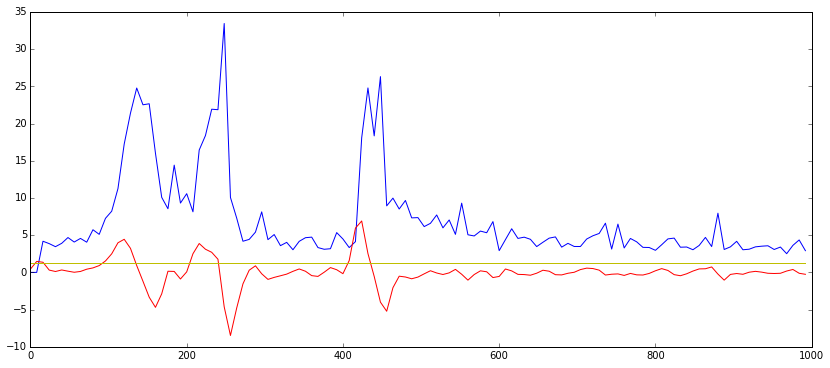

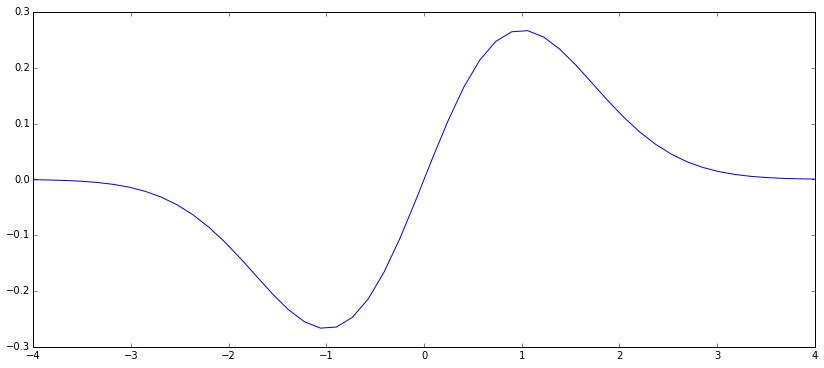

In [19]:
def gaussianderive(x, sigma=1., mu=0.):
    po = -(x-mu)*(x-mu)/2./sigma/sigma
    return (x-mu)*np.exp(po)/sigma/sigma/sigma/np.sqrt(2+np.pi)

y = distances_array[L0:L1]
x = fseconds[L0:L1]

from scipy.ndimage.filters import gaussian_filter1d
SIGMA = 1.0
gf = gaussian_filter1d(y, SIGMA, order = 1)

_ = plt.plot(x, y, 'b', x, gf, 'r', x, [1.2]*len(x), 'y')
plt.figure()
print gaussianderive(np.array([-2, -1, 0, 1, 2]), sigma=SIGMA)
xx = np.linspace(-4, 4)
_ = plt.plot(xx, gaussianderive(xx, sigma=SIGMA))

In [20]:
gtrue = []
with open("analysis2.csv") as gtruthfile:
    for row in gtruthfile:
        row_data = row.split("\t")
        if row_data[0] == os.path.basename(fname) and int(row_data[1]) <= len(fseconds)*STEP_FRAMES:
            gtrue.append({"begin": int(row_data[1]), "end": int(row_data[2]), "touched": 0})
TP = 0
TN = len(fseconds) - len(gtrue)
FP = 0
FN = 0
for scene in scenes[1:]:
    border = int(scene['start'])
    print border, ":", 
    touched = 0
    for gtentry in gtrue:
        if gtentry['begin']-STEP_FRAMES <= border <= gtentry['end']+STEP_FRAMES:
            print gtentry['begin'] , gtentry['end'], '//',
            gtentry['touched'] = 1
            TP += 1
            touched = 1
    if touched == 0:
        FP += 1
    print
FN = len(gtrue) - sum([o['touched'] for o in gtrue])
for o in gtrue:
    if o['touched'] == 0:
        print 'Missed', o['begin'], o['end']

print 'TP', TP, 'FP', FP, 'TN', TN, 'FN', FN
print 'Precision', 1.0*TP/(TP+FP), 'Recall', 1.0*TP/(TP+FN)

248 : 74 240 //
424 : 424 657 //
1424 : 1417 1553 //
Missed 2302 2361
Missed 2633 3407
Missed 3725 3798
Missed 3878 3903
Missed 3879 3949
TP 3 FP 0 TN 618 FN 5
Precision 1.0 Recall 0.375


In [ ]:
len(gtrue)

In [ ]:
[o['touched'] for o in gtrue]

In [ ]:
inputs